# Introduction
***
Notebook **#2-ensemble_modelling_daun_singkong_eksperimen_6** mengimplementasikan sesuai tahapan sesuai skenario 6 pada notes di drive: <br>
- Melakukan konfigurasi parameter terbaik pada single classifier dari split dataset yang dihasilkan 

# Import Libraries

In [3]:
!pip install collinearity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for collinearity: filename=collinearity-0.6.1-py3-none-any.whl size=4459 sha256=92ca899cbccf22ca7c2f2de42c689ecdef444e03f73141900c22730a6044cc30
  Stored in directory: /root/.cache/pip/wheels/31/bf/74/0a475ad9095545c56fe02d678ccd38739baa81513e877d91ca
Successfully built collinearity


In [34]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# visualization purpose
import matplotlib.pyplot as plt

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from collinearity import SelectNonCollinear
from sklearn.decomposition import PCA

# utils
import pickle

#
#from models.model_ensembles import EnsembleStacking
from google.colab import files, drive
drive.mount('/content/gdrive', force_remount=True)

src = list(files.upload().values())[0]
open('model_ensembles.py','wb').write(src)
from model_ensembles import EnsembleStacking

Mounted at /content/gdrive


Saving model_ensembles.py to model_ensembles (2).py


# Load Data After Preprocessing

In [6]:
dataset_daun_singkong_after_preprocessing = pickle.load(open('gdrive/My Drive/ITS_S2/KK/data_daun_singkong_after_preprocessing.pkl', 'rb'))
X_train = dataset_daun_singkong_after_preprocessing['training']['X']
y_train = dataset_daun_singkong_after_preprocessing['training']['y']
X_test = dataset_daun_singkong_after_preprocessing['testing']['X']
y_test = dataset_daun_singkong_after_preprocessing['testing']['y']

In [7]:
# sampling data
# X_train = X_train[:1000]
# X_test = X_test[:1000]
# y_train = y_train[:1000]
# y_test = y_train[:1000]

# Defining Global Variables 

In [8]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for MLP
max_iter=400 
batch_size=32 
verbose=0
n_iter_no_change=20

# Defining Global Functions

In [9]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            all_sub_model_name = list()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)
                all_sub_model_name.append(sub_model_name)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            df_results_for_each_classifiers = pd.DataFrame(all_predicted_results[model_name])
            df_results_for_each_classifiers.columns = [model_name+"_"+sub_model_name for sub_model_name in all_sub_model_name]
            list_of_majority_voting_each_models.append(df_results_for_each_classifiers)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

# Modelling

## Create Stacking ML Ensemble from 5-fold cross-validation

In [10]:
ensemble_classifiers = EnsembleStacking(X_train, y_train, X_test, y_test, kfold).train_ensemble()

In [11]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results = list()
for model in ensemble_classifiers.keys():
    ensemble_classifiers_results.append(pd.DataFrame(ensemble_classifiers[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results = pd.concat(ensemble_classifiers_results, axis=0)

In [12]:
ensemble_classifiers_results

,train,training,validation,testing
model-5,SVC(),0.625939,0.622371,0.625389
model-4,SVC(),0.626022,0.624374,0.625078
model-3,SVC(),0.625104,0.622705,0.624455
model-1,SVC(),0.624238,0.622497,0.623209
model-2,SVC(),0.623237,0.624499,0.622897
model-4,LogisticRegression(solver='newton-cg'),0.625438,0.626377,0.625545
model-3,LogisticRegression(solver='newton-cg'),0.625772,0.62571,0.624766
model-5,LogisticRegression(solver='newton-cg'),0.626273,0.624708,0.624455
model-1,LogisticRegression(solver='newton-cg'),0.626826,0.623164,0.623832
model-2,LogisticRegression(solver='newton-cg'),0.624405,0.626502,0.623832


## Create new input Training from the stacking ensemble ML

In [13]:
new_input_training_features = create_new_input_features(
    ensemble_classifiers, 
    X_train,
    y_train
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [14]:
new_input_training_features

,svm_model-1,svm_model-2,svm_model-3,svm_model-4,svm_model-5,logreg_model-1,logreg_model-2,logreg_model-3,logreg_model-4,logreg_model-5,...,naive_bayes_model-2,naive_bayes_model-3,naive_bayes_model-4,naive_bayes_model-5,decision_tree_model-1,decision_tree_model-2,decision_tree_model-3,decision_tree_model-4,decision_tree_model-5,ground_truth
0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,4,3,4,4,4,4
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,1,1,1,1,1,1
2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,2,1,1,1,1,1
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,4,1,4,4,4,4
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14972,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,1,3,3,3
14973,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
14974,3,3,3,3,3,4,4,4,4,4,...,3,3,3,3,1,1,1,3,1,1
14975,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


## Feature selection from new input features

In [15]:
X_new_input_features = new_input_training_features.drop(['ground_truth'], axis=1)
y_new_input_features = new_input_training_features['ground_truth'].copy()

In [16]:
X_new_input_features.shape

(14977, 20)

### Feature Selection using ChiSquare

#### Calculate feature importance for all feature

In [17]:
fs_chi_square = SelectKBest(score_func=chi2, k='all')
fs_chi_square.fit(X_new_input_features, y_new_input_features)
X_train_fs_chi_square = fs_chi_square.transform(X_new_input_features)

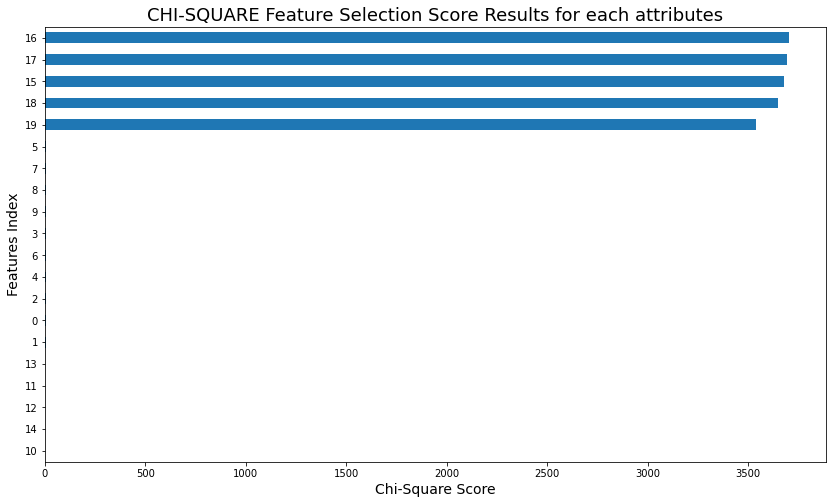

In [18]:
chi2_series = pd.Series(fs_chi_square.scores_).sort_values(ascending=True)
plt.figure(figsize=(14,8))
plt.title('CHI-SQUARE Feature Selection Score Results for each attributes', size=18)
chi2_series.plot(kind='barh')
plt.ylabel('Features Index', size=14)
plt.xlabel('Chi-Square Score', size=14)
plt.show()

#### Select top best feature

In [19]:
# select for 4 top features
fs_chi_square = SelectKBest(score_func=chi2, k=4)
fs_chi_square.fit(X_new_input_features, y_new_input_features)
X_train_fs_chi_square = fs_chi_square.transform(X_new_input_features)

In [20]:
X_train_fs_chi_square

array([[4, 3, 4, 4],
       [1, 1, 1, 1],
       [2, 1, 1, 1],
       ...,
       [1, 1, 1, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3]])

#### Feed Selected New Input Features into ANN

In [21]:
# split X and y from new_input_features before feeding to ANN
new_X_train_chi_square = X_train_fs_chi_square
new_y_train_chi_square = y_new_input_features.copy()

# feed new X and new y into ANN
ann_model_fs_chi_square = MLPClassifier(max_iter=max_iter, batch_size=batch_size, verbose=verbose, n_iter_no_change=n_iter_no_change)
ann_model_fs_chi_square.fit(new_X_train_chi_square, new_y_train_chi_square)

predicted_ann_train_chi_square = ann_model_fs_chi_square.predict(new_X_train_chi_square)

# print final results classification
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Data = ", accuracy_score(new_y_train_chi_square, predicted_ann_train_chi_square))

Final Accuracy Score [Mls Ensembles + ANN] on Training Data =  1.0


## Tuning the hyper-parameters of an single classifier

Making Classification Score

In [58]:
def output_classification_score(name_the_classifier, y_test, y_pred):
  print('\t\tResult Score {}'.format(name_the_classifier.upper()))
  print()
  print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
  print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
  print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
  print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
  print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
  print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

  print()
  print()
  print(classification_report(y_test, y_pred))

# SVM

In [79]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, precision_score, fbeta_score
param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
               'C': [50, 10, 1.0, 0.1, 0.01]}
svm_estimator = SVC(gamma='scale')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
svm_result = HalvingGridSearchCV(svm_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(X_train, y_train)
y_pred_svm = svm_result.predict(X_test)

In [80]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (svm_result.best_score_, svm_result.best_params_))
means = svm_result.cv_results_['mean_test_score']
stds = svm_result.cv_results_['std_test_score']
params = svm_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.638338 using Best Hyperparameters: {'C': 50, 'kernel': 'rbf'}
0.625806 (0.052487) with: {'C': 50, 'kernel': 'linear'}
0.608961 (0.045997) with: {'C': 50, 'kernel': 'poly'}
0.626882 (0.052615) with: {'C': 50, 'kernel': 'rbf'}
0.577778 (0.056349) with: {'C': 50, 'kernel': 'sigmoid'}
0.624731 (0.054993) with: {'C': 10, 'kernel': 'linear'}
0.622222 (0.049721) with: {'C': 10, 'kernel': 'poly'}
0.626523 (0.048719) with: {'C': 10, 'kernel': 'rbf'}
0.614337 (0.057553) with: {'C': 10, 'kernel': 'sigmoid'}
0.626882 (0.053917) with: {'C': 1.0, 'kernel': 'linear'}
0.626165 (0.053453) with: {'C': 1.0, 'kernel': 'poly'}
0.626165 (0.053884) with: {'C': 1.0, 'kernel': 'rbf'}
0.626882 (0.053917) with: {'C': 1.0, 'kernel': 'sigmoid'}
0.626882 (0.053917) with: {'C': 0.1, 'kernel': 'linear'}
0.627240 (0.052921) with: {'C': 0.1, 'kernel': 'poly'}
0.626882 (0.053917) with: {'C': 0.1, 'kernel': 'rbf'}
0.626882 (0.053917) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.626882 (0.053917) with: {'C': 0.01

In [84]:
output_classification_score("Result SVM", y_test, y_pred_svm)

		Result Score RESULT SVM

	Akurasi Score:  0.6390965732087227
	Macro Recall Score:  0.2636787951490088
	Macro Precision Score:  0.4663396585603875
	Macro F1-score Score:  0.2581794283984253
	Macro F2-score Score:  0.25607094951717363
	Macro F0.5-score Score:  0.29266120202267576


              precision    recall  f1-score   support

           0       0.31      0.03      0.06       326
           1       0.47      0.07      0.13       657
           2       0.42      0.01      0.01       716
           3       0.65      0.98      0.78      3948
           4       0.48      0.23      0.31       773

    accuracy                           0.64      6420
   macro avg       0.47      0.26      0.26      6420
weighted avg       0.57      0.64      0.54      6420



# Logistic Regression

In [55]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
param_grid = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'penalty': ['none', 'l1', 'l2', 'elasticnet'],
               'C': [50, 10, 1.0, 0.1, 0.01]}
base_estimator = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lr_result = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(X_train, y_train)
y_pred_lr = lr_result.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1350 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is

In [56]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (lr_result.best_score_, lr_result.best_params_))
means = lr_result.cv_results_['mean_test_score']
stds = lr_result.cv_results_['std_test_score']
params = lr_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.631205 using Best Hyperparameters: {'C': 50, 'penalty': 'none', 'solver': 'lbfgs'}
0.541034 (0.084603) with: {'C': 50, 'penalty': 'none', 'solver': 'newton-cg'}
0.567011 (0.096057) with: {'C': 50, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'none', 'solver': 'liblinear'}
0.588276 (0.087248) with: {'C': 50, 'penalty': 'none', 'solver': 'sag'}
0.587126 (0.081973) with: {'C': 50, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'lbfgs'}
0.579157 (0.092278) with: {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'sag'}
0.586015 (0.082468) with: {'C': 50, 'penalty': 'l1', 'solver': 'saga'}
0.590536 (0.086135) with: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.593908 (0.089932) with: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.590498 (0.087

In [60]:
output_classification_score("Result Logistic Regression", y_test, y_pred_lr)

		Result Score RESULT LOGISTIC REGRESSION

	Akurasi Score:  0.6292834890965732
	Macro Recall Score:  0.258713507723472
	Macro Precision Score:  0.4174356108534708
	Macro F1-score Score:  0.25376375925752515
	Macro F2-score Score:  0.2517455369068147
	Macro F0.5-score Score:  0.2857140125917772


              precision    recall  f1-score   support

           0       0.14      0.02      0.03       326
           1       0.36      0.08      0.14       657
           2       0.54      0.03      0.06       716
           3       0.66      0.96      0.78      3948
           4       0.40      0.20      0.27       773

    accuracy                           0.63      6420
   macro avg       0.42      0.26      0.25      6420
weighted avg       0.55      0.63      0.53      6420



# Naive Bayes

In [67]:
param_grid = {"alpha": [50, 10, 1.0, 0.1, 0.01],
              "fit_prior": (True, False),
              'class_prior': [None, [.1,.9],[.2, .8]],
            }
base_estimator = MultinomialNB()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
nb_result = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(X_train, y_train)
y_pred_nb = nb_result.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py", line 693, in fit
    self._update_class_log_prior(class_prior=class_prior)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py", line 529, in _update_class_log_prior
    raise ValueError("Number of priors must match number of c

In [68]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (nb_result.best_score_, nb_result.best_params_))
means = nb_result.cv_results_['mean_test_score']
stds = nb_result.cv_results_['std_test_score']
params = nb_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.615064 using Best Hyperparameters: {'alpha': 50, 'class_prior': None, 'fit_prior': True}
0.617921 (0.047339) with: {'alpha': 50, 'class_prior': None, 'fit_prior': True}
0.572401 (0.044045) with: {'alpha': 50, 'class_prior': None, 'fit_prior': False}
0.000000 (0.000000) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.000000 (0.000000) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.000000 (0.000000) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': True}
0.000000 (0.000000) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': False}
0.617563 (0.047090) with: {'alpha': 10, 'class_prior': None, 'fit_prior': True}
0.502151 (0.051654) with: {'alpha': 10, 'class_prior': None, 'fit_prior': False}
0.000000 (0.000000) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.000000 (0.000000) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.000000 (0.000000) with: {'alpha': 10, 'class_prior': [

In [77]:
output_classification_score("Result Naive Bayes", y_test, y_pred_nb)

		Result Score RESULT NAIVE BAYES

	Akurasi Score:  0.6149532710280374
	Macro Recall Score:  0.20076126632524183
	Macro Precision Score:  0.2087456282996592
	Macro F1-score Score:  0.15410913027653514
	Macro F2-score Score:  0.17880120850775105
	Macro F0.5-score Score:  0.13765658907082265


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       326
           1       0.43      0.00      0.01       657
           2       0.00      0.00      0.00       716
           3       0.62      1.00      0.76      3948
           4       0.00      0.00      0.00       773

    accuracy                           0.61      6420
   macro avg       0.21      0.20      0.15      6420
weighted avg       0.42      0.61      0.47      6420



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

# Desicion Tree

In [74]:
param_grid = {'criterion': ('gini', 'entropy', 'log_loss'),
               'ccp_alpha': [50, 10, 1.0, 0.1, 0.01],
              'splitter': ('best', 'random')
              }
base_estimator = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
dt_result = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(X_train, y_train)
y_pred_dt = dt_result.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_mes

In [75]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (dt_result.best_score_, dt_result.best_params_))
means = dt_result.cv_results_['mean_test_score']
stds = dt_result.cv_results_['std_test_score']
params = dt_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.614931 using Best Hyperparameters: {'ccp_alpha': 1.0, 'criterion': 'entropy', 'splitter': 'random'}
0.621147 (0.037934) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'best'}
0.621147 (0.037934) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'random'}
0.621147 (0.037934) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'best'}
0.621147 (0.037934) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'random'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'best'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'random'}
0.621147 (0.037934) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'best'}
0.621147 (0.037934) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'random'}
0.621147 (0.037934) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'best'}
0.621147 (0.037934) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'random'}
0.0000

In [76]:
output_classification_score("Result Decision Tree", y_test, y_pred_dt)

		Result Score RESULT DECISION TREE

	Akurasi Score:  0.6149532710280374
	Macro Recall Score:  0.2
	Macro Precision Score:  0.12299065420560748
	Macro F1-score Score:  0.15231481481481482
	Macro F2-score Score:  0.17774176121015667
	Macro F0.5-score Score:  0.1332523288780883


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       326
           1       0.00      0.00      0.00       657
           2       0.00      0.00      0.00       716
           3       0.61      1.00      0.76      3948
           4       0.00      0.00      0.00       773

    accuracy                           0.61      6420
   macro avg       0.12      0.20      0.15      6420
weighted avg       0.38      0.61      0.47      6420



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

### Feature Reduction using Principal Component Analysis

In [85]:
# Fit training data into PCA calculation
pca_model = PCA()
pca_model.fit(X_new_input_features)

pca_component_results = pd.DataFrame({
    'Komponen ke-': [i+1 for i in range(0,X_new_input_features.shape[1])],
    'Variance': pca_model.explained_variance_,
    'Proporsi Variance': pca_model.explained_variance_ratio_,
    'Kumulatif Proporsi Variance': pca_model.explained_variance_ratio_.cumsum()
})

In [86]:
pca_component_results

,Komponen ke-,Variance,Proporsi Variance,Kumulatif Proporsi Variance
0,1,3.428265e+00,5.977376e-01,0.597738
1,2,6.474128e-01,1.128801e-01,0.710618
2,3,3.843473e-01,6.701316e-02,0.777631
3,4,3.664737e-01,6.389679e-02,0.841528
4,5,3.607718e-01,6.290263e-02,0.904430
5,6,3.560108e-01,6.207252e-02,0.966503
6,7,1.172321e-01,2.044009e-02,0.986943
7,8,1.930111e-02,3.365259e-03,0.990308
8,9,1.268061e-02,2.210937e-03,0.992519
9,10,9.079630e-03,1.583086e-03,0.994102


In [87]:
threshold_cumsum = 0.97
best_pca_component = pca_component_results[
    pca_component_results['Kumulatif Proporsi Variance']>=threshold_cumsum
].index[0]+1
print('Best Principal Component using = ', best_pca_component)

Best Principal Component using =  7


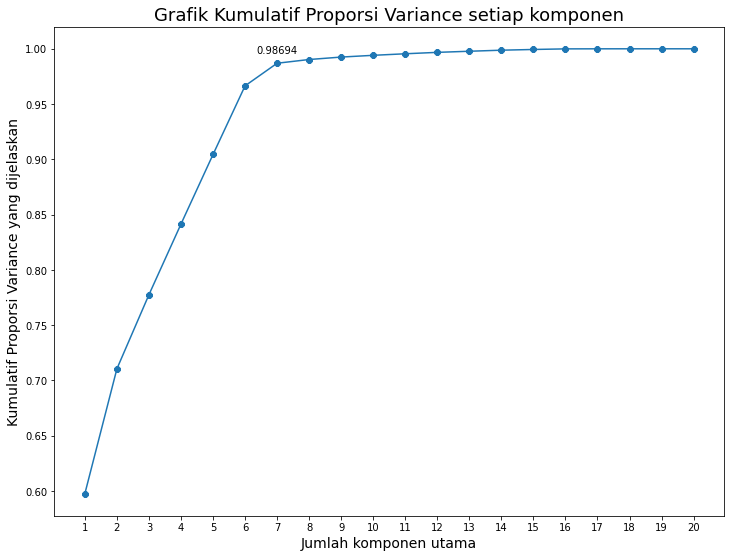

In [88]:
cumsum_component_explained = pca_model.explained_variance_ratio_.cumsum()
customs_labels = [i+1 for i in range(0,X_new_input_features.shape[1])]
string_label = best_pca_component
xs = range(0,X_new_input_features.shape[1])

plt.figure(figsize=(12,9))
pd.Series(cumsum_component_explained).plot(marker="8")
plt.xticks(ticks=xs, labels=customs_labels)
plt.title('Grafik Kumulatif Proporsi Variance setiap komponen', size=18)
plt.xlabel('Jumlah komponen utama', size=14)
plt.ylabel('Kumulatif Proporsi Variance yang dijelaskan',size=14)

label_index = customs_labels.index(best_pca_component)
xs_index = xs[label_index]
text = round(pca_component_results[
    pca_component_results['Kumulatif Proporsi Variance']>=threshold_cumsum
].iloc[0]['Kumulatif Proporsi Variance'],5)
plt.annotate(
    text, 
    (xs_index,text),
    textcoords="offset points",
    xytext=(0,10),
    ha='center'
)

plt.show()

#### Select top best principal component

In [89]:
pca_scaler = PCA(n_components=best_pca_component)
pca_scaler.fit(X_new_input_features)
X_train_pca = pca_scaler.transform(X_new_input_features)

#### Feed Selected New Input Features into ANN

In [90]:
# split X and y from new_input_features before feeding to ANN
new_X_train_pca = X_train_pca
new_y_train_pca = y_new_input_features

# feed new X and new y into ANN
ann_model_pca = MLPClassifier(max_iter=max_iter, batch_size=batch_size, verbose=verbose, n_iter_no_change=n_iter_no_change)
ann_model_pca.fit(new_X_train_pca, new_y_train_pca)

predicted_ann_train_pca = ann_model_pca.predict(new_X_train_pca)

# print final results classification
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Data = ", accuracy_score(new_y_train_pca, predicted_ann_train_pca))

Final Accuracy Score [Mls Ensembles + ANN] on Training Data =  1.0
